# DD2367 - Programming Assignment II: Quantum Circuits and Gates - Bell's Circuit and SWAP Test #

Authors: Scott McHaffie, Jai Iyer, Venkatesh Elayaraja

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from circleNotationClass import QubitSystem

DTYPE = np.complex128

# Task 1 - State‑Vector Quantum Computer Simulator  #

## 1.1 - State‑vector representation ##

In [5]:
import numpy as np

DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n

# Example
psi = ket00()
print (psi)
assert np.isclose(np.linalg.norm(psi), 1.0), "State is not normalized!"

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


For a 2-qubit system, the computational basis is ordered as $|q_0q_1\rangle$, with $q_0$ as the most significant qubit (MSB). This maps the bitstrings to indices as follows: $|00\rangle \to 0$, $|01\rangle \to 1$, $|10\rangle \to 2$, and $|11\rangle \to 3$.

This ordering convention is widely adopted in quantum computing frameworks and ensures consistency when applying quantum gates and interpreting measurement results.

## 1.2 - Quantum gate implementation ##

In [6]:
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2) # kronecker product is the tensor product
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

`CNOT_01` matrix implements a controlled-NOT gate with **qubit `q0` as the control** and **qubit `q1` as the target**.

The four basis states of the 2-qubit system are ordered as follows:

* $|00\rangle = [1, 0, 0, 0]^T$
* $|01\rangle = [0, 1, 0, 0]^T$
* $|10\rangle = [0, 0, 1, 0]^T$
* $|11\rangle = [0, 0, 0, 1]^T$

A CNOT gate flips the target qubit if and only if the control qubit is $|1\rangle$.

* **When control `q0` is 0:**
    * $CNOT_{01} |00\rangle = |00\rangle$
    * $CNOT_{01} |01\rangle = |01\rangle$
    In both cases, the target qubit `q1` remains unchanged, which is the correct behavior.

* **When control `q0` is 1:**
    * $CNOT_{01} |10\rangle = [0, 0, 0, 1]^T = |11\rangle$
    * $CNOT_{01} |11\rangle = [0, 0, 1, 0]^T = |10\rangle$
    In both cases, the target qubit `q1` is flipped.

This convention is consistent with the expand_1q() function where t=0 acts on q0 (MSB) via np.kron(U, I2) and t=1 acts on q1 (LSB) via np.kron(I2, U).

## 1.3 - Circuit simulation: Bell state ##

In [7]:
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]
print("Bell state vector:", np.round(psi_bell, 6))

Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]



The resulting state vector confirms the successful creation of the Bell state $|\Phi^+\rangle$.

The theoretical Bell state is given by the formula $|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$.

Its vector representation:

  * The basis state $|00\rangle$ corresponds to the vector $[1, 0, 0, 0]^T$.
  * The basis state $|11\rangle$ corresponds to the vector $[0, 0, 0, 1]^T$.
  * Therefore, the state $|\Phi^+\rangle$ is $\frac{1}{\sqrt{2}}([1, 0, 0, 0]^T + [0, 0, 0, 1]^T) = \frac{1}{\sqrt{2}}[1, 0, 0, 1]^T$.

Since $\frac{1}{\sqrt{2}} \approx 0.707107$, the expected vector is approximately `[0.707107, 0, 0, 0.707107]` which is what we can see in the above print statement.

## 1.4 - Output, verification, and circle‑plot comparison ##

{'00': 4983, '01': 0, '10': 0, '11': 5017}


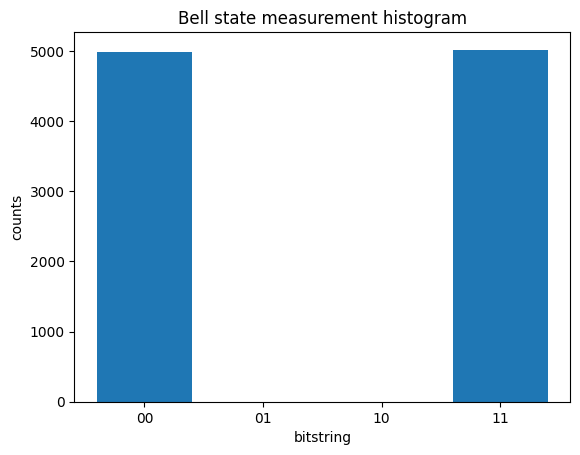

In [11]:
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()

Yes, a Bell state like $|\Phi^+\rangle$  = $|00\rangle$  + $|11\rangle$ $\frac{1}{\sqrt{2}}$, the measurement counts should match theoretical expectations within sampling error.

With 10,000 shots, we expect to measure "00" approximately 5,000 times and "11" approximately 5,000 times. The histogram from your code will show counts very close to these values (e.g., from our run we got `{'00': 4983, '01': 0, '10': 0, '11': 5017}`), with the small deviations being the result of the random nature of quantum measurement.

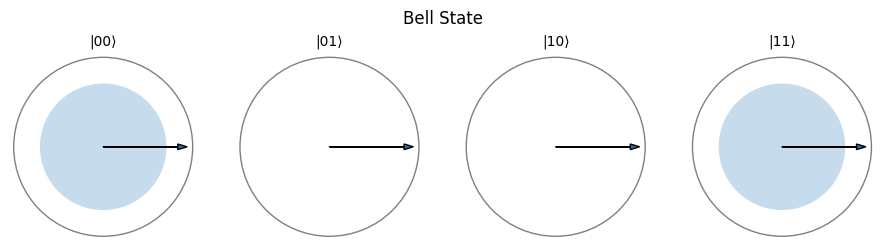

In [5]:
from circleNotationClass import QubitSystem

QubitSystem(psi_bell, label="Bell State").viz_circle()

The circle plot confirms the algebraic state vector and the measurement histogram.

* Dominant Components: The plot clearly shows large, filled circles for the  $|00\rangle$  and  $|11\rangle$ basis states, while  $|01\rangle$ and | $|10\rangle$ have no circles. The radii of the circles represent the magnitude of the amplitudes. Because the circles for  $|00\rangle$  and  $|11\rangle$ are equal in size, it visually confirms they have equal probability and are the only two components of the state.

* Relative Phase: The red arrows represent the phase of each amplitude. For both  $|00\rangle$  and  $|11\rangle$, the amplitudes are positive real numbers ( $\frac{1}{\sqrt{2}}$ ), which corresponds to a phase angle of 0. The plot shows this by having both arrows point in the exact same direction (horizontally to the right, or the "3 o'clock" position). This indicates that the relative phase between the two components is zero—they are perfectly in phase.

# Task 2 - State‑Vector SWAP Test  #

In [25]:
def expand_1q_n(U: np.ndarray, t: int, n: int) -> np.ndarray:
    op = np.array([[1]], dtype=U.dtype)
    for q in range(n):
        op = np.kron(op, U if q == t else I2)
    return op


# Apply CSWAP, with ancilla as control
P0 = np.array([[1,0],[0,0]], dtype=DTYPE)  # |0><0| on ancilla
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)  # |1><1| on ancilla
SWAP_A0_B0 = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
], dtype=DTYPE)  # SWAP on A0 and B0
CSWAP = (np.kron(P0, np.eye(4)) + np.kron(P1, SWAP_A0_B0)) # CSWAP with ancilla as control

# function to easily call three different 
def Task2_automator(Psi: np.ndarray, Phi: np.ndarray) -> None:
    # important! remember to normalize
    Psi = Psi/np.linalg.norm(Psi); Phi = Phi/np.linalg.norm(Phi)

    # check the normalization was successful
    assert np.isclose(np.sum(np.abs(Psi)**2), 1), "Psi is not normalized!"
    assert np.isclose(np.sum(np.abs(Phi)**2), 1), "Phi is not normalized!"

    # initial state (|output A0 B0>)                                #   q_ancilla x q_A0 x q_B0
    init = np.kron(np.array([1,0], dtype=DTYPE), np.kron(Psi, Phi))  # |0>_output ⊗ |ψ>_A ⊗ |φ>_B
    print ("Initial state:\n", init)
    QubitSystem(init, label="Initial State").viz_circle()

    # Hs
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init
    # print("H on q_ancilla:\n", state)
    # QubitSystem(state, label="H on q_ancilla").viz_circle()


    state = CSWAP @ state
    # print("CSWAP with q_ancillas as control:\n", state)
    # QubitSystem(state, label="CSWAP with q_ancillas as control").viz_circle()

    state = U_Ho @ state
    print("Final state:\n", state)
    QubitSystem(state, label="Final State").viz_circle()

    # readout and fidelity from outer bit
    probs = np.abs(state)**2
    prob_1 = probs[4:].sum()   # indices with output=1
    F_hat = 1 - 2*prob_1
    print ("SWAP Test Fidelity: F_hat = ", F_hat)

    # inner product (exact fidelity check)
    F_exact = float(np.abs(np.vdot(Psi/np.linalg.norm(Psi), Phi/np.linalg.norm(Phi)))**2)
    print ("Exact Fidelity: F_exact = ", F_exact)

    return



### Test 1: $|\psi \rangle = |\phi \rangle = |0 \rangle$ ###

Initial state:
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


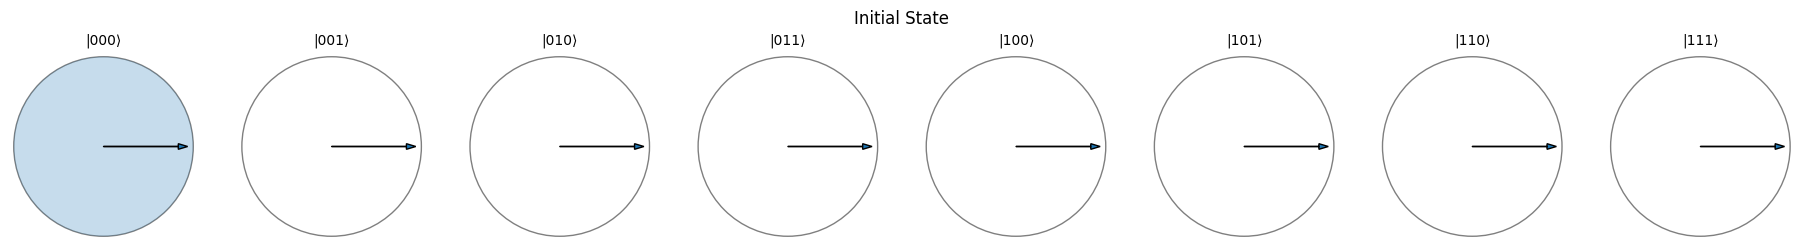

Final state:
 [ 1.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j -2.23711432e-17+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j]


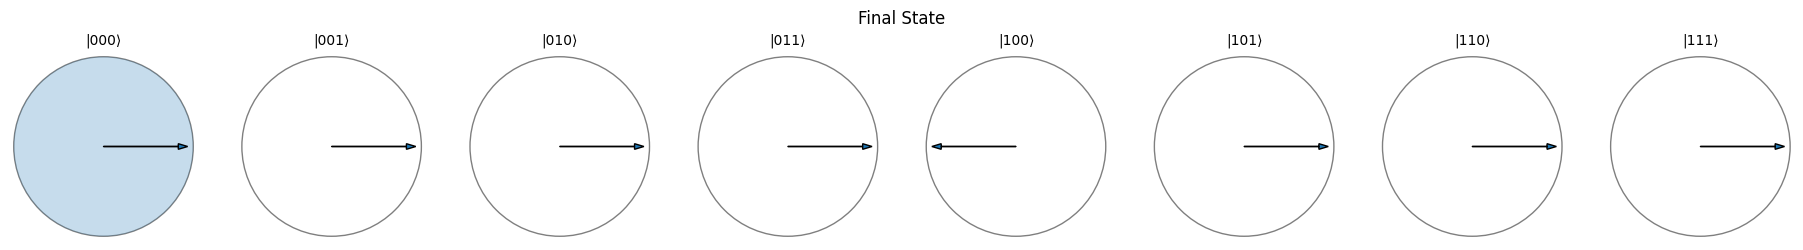

SWAP Test Fidelity: F_hat =  1.0
Exact Fidelity: F_exact =  1.0


In [26]:
# initialize phi
psi = [1, 0]
phi = [1, 0]

Task2_automator(psi, phi)

### Test 2: $|\psi \rangle = |0\rangle$, $|\phi \rangle = |1 \rangle$ ###

Initial state:
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


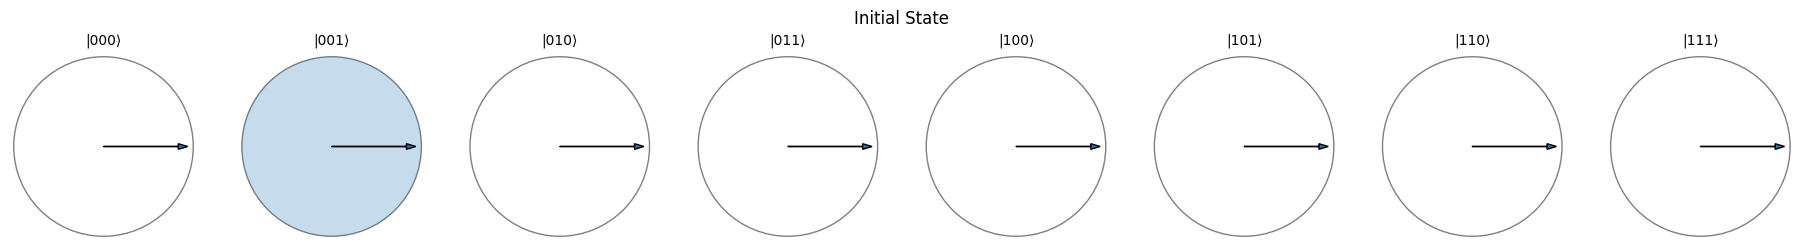

Final state:
 [ 0. +0.j  0.5+0.j  0.5+0.j  0. +0.j  0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]


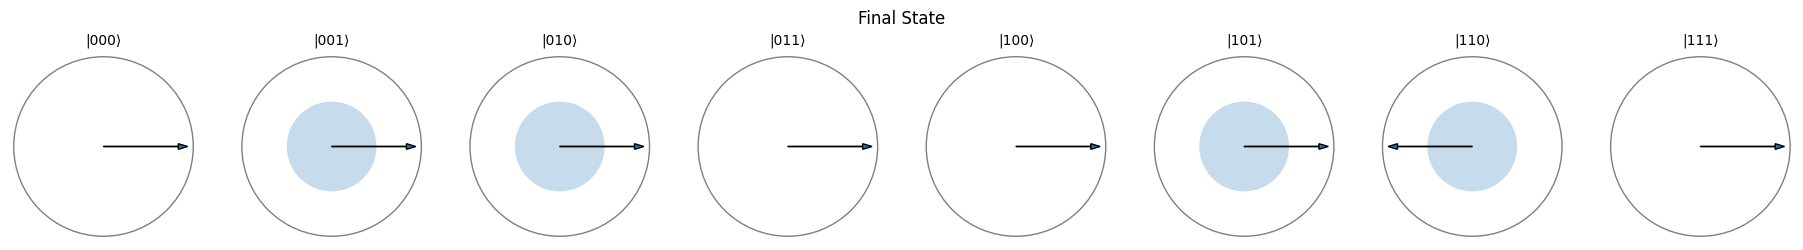

SWAP Test Fidelity: F_hat =  4.440892098500626e-16
Exact Fidelity: F_exact =  0.0


In [27]:
# initialize phi
psi = [1, 0]
phi = [0, 1]

Task2_automator(psi, phi)

### Test 3: $|\psi \rangle = |+ \rangle$, $|\phi \rangle = |0 \rangle$ ###

Initial state:
 [0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


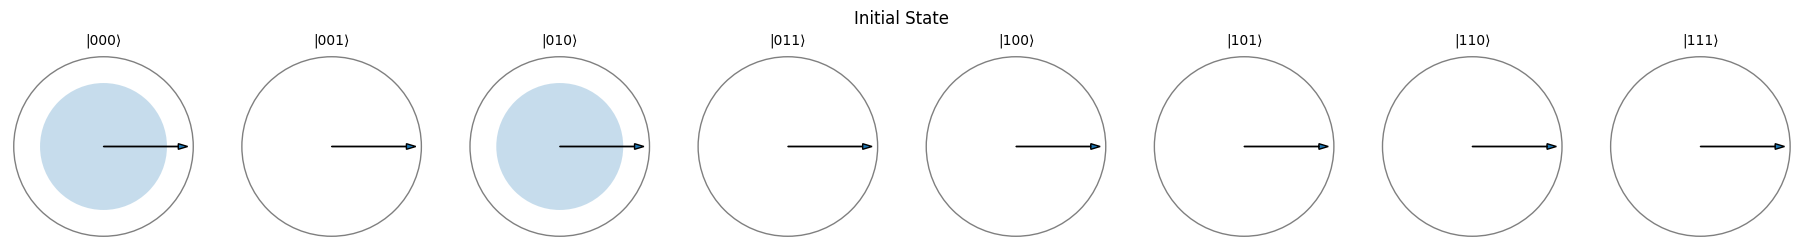

Final state:
 [ 0.70710678+0.j  0.35355339+0.j  0.35355339+0.j  0.        +0.j
  0.        +0.j -0.35355339+0.j  0.35355339+0.j  0.        +0.j]


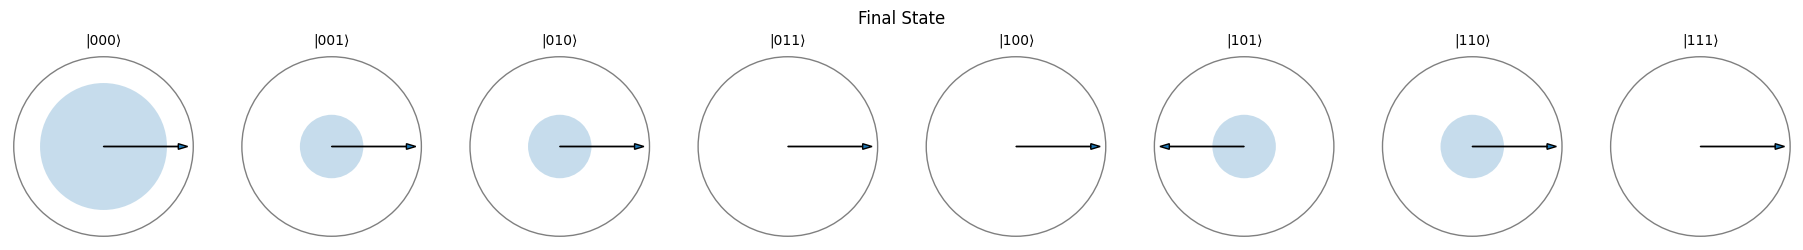

SWAP Test Fidelity: F_hat =  0.5000000000000001
Exact Fidelity: F_exact =  0.5000000000000001


In [ ]:
# initialize phi
psi = [1/np.sqrt(2), 1/np.sqrt(2)]
phi = [1, 0]

Task2_automator(psi, phi)

For the three test cases above, both the initial and final states are shown. Additionally, the SWAP test fidelity (F_hat) and the exact fidelity (F_exact) are printed. These values are in agreement with each other, short of some small rounding errors. We followed the ordering of the bits as per the assignment instructions, (|0>_output ⊗ |ψ>_A ⊗ |φ>_B), with the MSB being the output bit.


All of the information regarding the overlap of the states is contained in the state of the output (or ancilla) qubit. Below I will prove this by deriving the equation used for fidelity, $F = 2 - P(\text{output}=1)$.

In the SWAP test circuit we apply a Hadamard on the output qubit, followed by the CSWAP gate, followed by another Hadamard gate. Let's take a look at this process mathematically. We begin with the state $\ket{\Psi}$:

$$
\begin{align*}
    \ket{\Psi} &= \ket{0} \otimes \ket{\psi} \otimes \ket{\phi} \\
    \Rightarrow H(0): \quad &= \frac{1}{\sqrt{2}} \left[ \ket{0} \otimes \ket{\psi} \otimes \ket{\phi} + \ket{1} \otimes \ket{\psi} \otimes \ket{\phi} \right] \\
    \Rightarrow CSWAP: \quad &= \frac{1}{\sqrt{2}} \left[ \ket{0} \otimes \ket{\psi} \otimes \ket{\phi} + \ket{1} \otimes \ket{\phi} \otimes \ket{\psi} \right] \\
    \Rightarrow H(0): \quad &= \frac{1}{2} \left[ \ket{0} \otimes \ket{\psi} \otimes \ket{\phi} + \ket{1} \otimes \ket{\psi} \otimes \ket{\phi} \right. \\
                                                   & \left. \quad \quad + \ket{0} \otimes \ket{\phi} \otimes \ket{\psi} - \ket{1} \otimes \ket{\phi} \otimes \ket{\psi} \right] \\
    &= \frac{1}{2} \left[ \ket{0} \otimes \left( \ket{\psi} \otimes \ket{\phi} + \ket{\phi} \otimes \ket{\psi} \right) + \ket{1} \otimes \left( \ket{\psi} \otimes \ket{\phi} - \ket{\phi} \otimes \ket{\psi} \right) \right]

\end{align*}
$$

From this final state we can calculate the probability of the output bit being in state $\ket{1}$ as:

$$
\begin{align*}
    P(\text{output}=1) &= \left| \frac{1}{2} \left( \ket{\psi} \otimes \ket{\phi} - \ket{\phi} \otimes \ket{\psi} \right) \right|^2 \\
    &= \frac{1}{4} \left[ 1 - 2 \braket{\psi|\phi} \braket{\phi | \psi} + 1 \right] \\
    &= \frac{1}{2} \left[ 1 - \braket{\psi|\phi} \braket{\phi | \psi} \right] \\
    &= \frac{1}{2} \left[ 1 - \left| \braket{\psi|\phi} \right|^2 \right] \\
\end{align*}
$$

We already know that the exact fidelity is given as $F = \left| \braket{\psi | \phi} \right|^2$, so we can rewrite the equation above with this substitution, as:

$$
\begin{align*}
    P(\text{output}=1) &= \frac{1}{2} \left[ 1 - F \right] ,
\end{align*}
$$

and rearrange for $F$ as:
$$
\begin{align*}
    2P(\text{output}=1) &= 1 - F \\
    F &= 1 - 2P(\text{output}=1) . 
\end{align*}
$$

This is why the fidelity (state overlap) is encoded in the output bit!


# Bonus Tasks - Quantum State Comparison with the Multiqubit SWAP Test #

## B.1 - Basis vs $|5\rangle$: design, simulate, evaluate ##

### Evaluation Protocol.

- Run 1: Reference : $ \ket R = \ket {100}$, Test : $\ket L = \ket {000} $
- Run 2: Reference : $ \ket R = \ket {100}$, Test : $\ket L = \ket {100} $

**Remarks.** By designing our SWAP test runs on the above set of reference and test states, we also perform a sanity check on the fidelity protocol by verifying the observed fidelities for **identical** and **orthonormal** states.

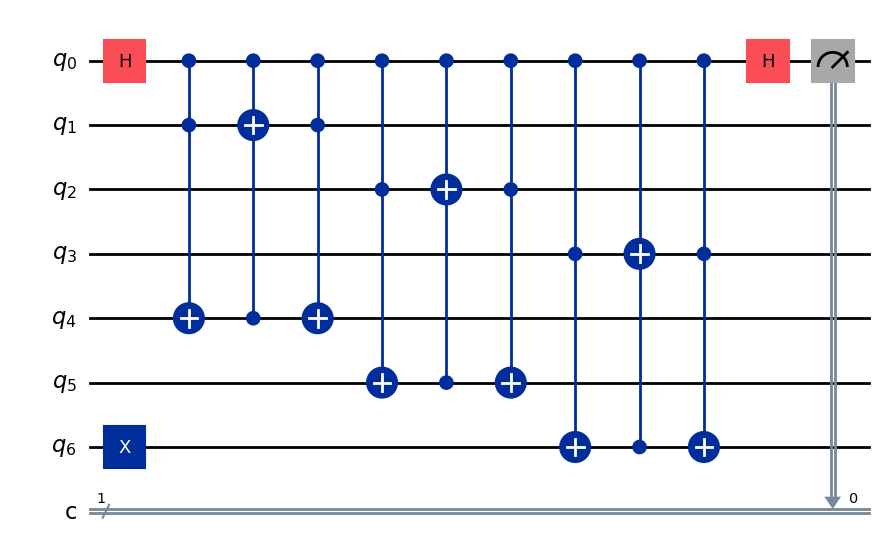

In [8]:
## RUN 1 ##

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

# Function to get statevector from Aer simulator
def statevector_from_aer(circ: QuantumCircuit) -> np.ndarray:
    backend = Aer.get_backend("aer_simulator_statevector")
    tqc = transpile(circ, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.get_statevector(tqc), dtype=np.complex128)

# Initialise R-register
Rqc = QuantumCircuit(3, name="R")
Rqc.x(2)

# Initialise L-register
Lqc = QuantumCircuit(3, name="L")

# Tensor Product of R and L registers - 6 qubits
STqc = Rqc.tensor(Lqc)

# Add ancilla qubit for control
Oqc = QuantumCircuit(1, 1, name="Output")

# Tensor Product with ancilla - 7 qubits
STqc = STqc.tensor(Oqc)

## Fidelity SWAP Test Circuit ##

# Step 1: Apply Hadamard to control
STqc.h(0)

# Step 2: C-SWAP gate: Implemented with 3 Toffoli gates
for i in range (1, 4):
    STqc.ccx(0, i, i+3)
    STqc.ccx(0, i+3, i)
    STqc.ccx(0, i, i+3)

# Step 3: Apply Hadamard to control again
STqc.h(0)

# Step 4: Measure the control qubit
STqc.measure(0, 0)
STqc.draw("mpl")

In [9]:
# Running multiple shots of the SWAP test and to evaluate <P(1)>
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator

# Run the circuit on the Aer simulator for 10,000 shots
sim_resultsST = BackendSamplerV2(backend=AerSimulator()).run([STqc], shots=10_000).result()
sim_countsST = sim_resultsST[0].data.c.get_counts()
sim_totalST = sum(sim_countsST.values())

# Dict of probabilities of |0> and |1>
sim_probsST = {bitstr: count / sim_totalST for bitstr, count in sim_countsST.items()}
print (sim_probsST)

# Get the probability of measuring '1' on the ancilla qubit P(1)
sim_prob1ST = sim_probsST.get('1', 0.0)

# Print fidelity estimate F = 1 - 2*P(1)
print ("Fidelity =", 1.0 - 2*sim_prob1ST)

{'0': 0.5016, '1': 0.4984}
Fidelity = 0.0031999999999999806


### Remarks on Fidelity SWAP Test implementation

In this part, we implemented the Fidelity SWAP test between two 3-qubit systems. The **R-register** encodes the **reference state**, the **L-register** encodes the **test state**, and the **Output Qubit** is used to control the SWAP operations. Finally, we measure the output qubit and report the frequency of measuring the states $\{\ket 0, \ket 1\}$. Below we describe some pertinent details regarding our implementation of the circuit.

**Implementation of CSWAP**: 

1. **Principle:** We designed our CSWAP gate to work as a controlled-cx-cx-cx SWAP gate, effectively a cascade of **three ccx (Toffoli) gates** 

2. **Distribution of Control:** The output qubit is always used as one of the control qubits, while the qubits to be swapped alternate as target and control qubits (as seen in the circuit drawing)

3. **Gates:** In this implementation, we use only 3-qubit ccx gates, in addition to the single-qubit X and Hadamard gates for qubit initialisation and enaction of the fidelity SWAP test protocol respectively

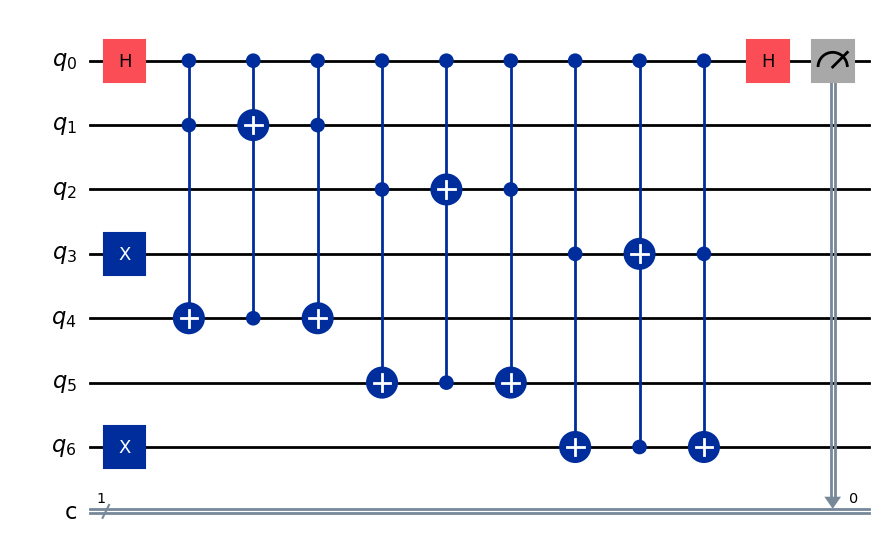

In [10]:
## RUN 2 ##

# Function to get statevector from Aer simulator
def statevector_from_aer(circ: QuantumCircuit) -> np.ndarray:
    backend = Aer.get_backend("aer_simulator_statevector")
    tqc = transpile(circ, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.get_statevector(tqc), dtype=np.complex128)

# Initialise R-register
Rqc = QuantumCircuit(3, name="R")
Rqc.x(2)

# Initialise L-register
Lqc = QuantumCircuit(3, name="L")
Lqc.x(2)

# Tensor Product of R and L registers - 6 qubits
STqc = Rqc.tensor(Lqc)

# Add ancilla qubit for control
Oqc = QuantumCircuit(1, 1, name="Output")

# Tensor Product with ancilla - 7 qubits
STqc = STqc.tensor(Oqc)

## Fidelity SWAP Test Circuit ##

# Step 1: Apply Hadamard to control
STqc.h(0)

# Step 2: C-SWAP gate: Implemented with 3 Toffoli gates
for i in range (1, 4):
    STqc.ccx(0, i, i+3)
    STqc.ccx(0, i+3, i)
    STqc.ccx(0, i, i+3)

# Step 3: Apply Hadamard to control again
STqc.h(0)

# Step 4: Measure the control qubit
STqc.measure(0, 0)
STqc.draw("mpl")

In [11]:
# Running multiple shots of the SWAP test and to evaluate <P(1)>
from qiskit.primitives import BackendSamplerV2
from qiskit_aer import AerSimulator

# Run the circuit on the Aer simulator for 10,000 shots
sim_resultsST = BackendSamplerV2(backend=AerSimulator()).run([STqc], shots=10_000).result()
sim_countsST = sim_resultsST[0].data.c.get_counts()
sim_totalST = sum(sim_countsST.values())

# Dict of probabilities of |0> and |1>
sim_probsST = {bitstr: count / sim_totalST for bitstr, count in sim_countsST.items()}
print (sim_probsST)

# Get the probability of measuring '1' on the ancilla qubit P(1)
sim_prob1ST = sim_probsST.get('1', 0.0)

# Print fidelity estimate F = 1 - 2*P(1)
print ("Fidelity =", 1.0 - 2*sim_prob1ST)

{'0': 1.0}
Fidelity = 1.0


### Analysis.

- **Run 1 (Different states)** When the reference and test states are orthonormal, the probabilities for measuring the output qubit in either $\ket 0$ or $\ket 1$ are 0.5 each. This results in obtaining $P(0) \approx P(1) \approx 0.5$ over the 10,000 shots, but not exactly equal. Hence, the fidelity estimate we evaluate deviates from the ideal value of 0.

- **Run 2 (Identical states)** When the reference and test states are identical, the probabilities for measuring the output qubit in either $\ket 0$ or $\ket 1$ are 1 and 0 respectively. This results in obtaining $P(0) = 1$ and $ P(1) = 0$ over the 10,000 shots, rendering the measurement essentially deterministic. Hence, the fidelity estimate we evaluate does not deviate from the ideal value of 1.

**Determination of test state fidelity to reference state** 

- If we wish to definitely state whether the test state is identical to or different from the reference state, we will need to run multiple shots of the Fidelity SWAP test and evaluate the mean fidelity. This is because only running a **single shot** runs the risk of obtaining $P(0) = 1$ and $ P(1) = 0$ for the different state case, giving us a false fidelity of 1. 

- Upon running a large number of shots (e.g., 10,000), the average fidelity of the will largely deviate from $F = 1$ in the different state case, as opposed to the identical state case which will persist to be $F = 1$. This provides us with a clear decision criterion (pseudocode):

    ```
    # Run the circuit on the Aer simulator for 10,000 shots
    
    if F == 1: 
        return 'Identical'
    else: 
        return 'Different'
    ```

    ----- 

## B.2 - Introducing superposition ##

### Evaluation Protocol.

Run over all $\ket k$ basis states for the R-register, while keep $\ket L$ fixed:

- Run $k$: $\ket R = \ket {k-1}$ for $k \in \{1, \dots, 8  \}$
- For all runs: $\ket L = \frac{1}{\sqrt{2}}\left[ \ket 0 + \ket 1 \right] \otimes \ket 0 \otimes \ket 0 $


In [12]:
# Function to initialise circuit based on input k and superposition in the L0 qubit

def init_qc(k: int):
    # R register initialisation 
    iRqc = QuantumCircuit(3, name="R")

    # specify state of R register based on k (input)
    binary_k = bin(k)[2:]
    binary_k = binary_k[::-1]
    for bin_val_idx in range(0, len(binary_k)):
        if binary_k[bin_val_idx] == '1':
            iRqc.x(bin_val_idx)
    
    # L register initialisation
    iLqc = QuantumCircuit(3, name="L")
    iLqc.h(2)

    # Tensor product of L & R registers (6-qubits)
    iSTqc = iRqc.tensor(iLqc)

    # Control Qubit & Classical Bit initialisation
    iOqc = QuantumCircuit(1, 1, name="Output")

    # Full tensor product (7-qubits)
    iSTqc = iSTqc.tensor(iOqc)
 
    ## FIDELITY SWAP TEST CIRCUIT ##
    # apply Hadamard to control
    iSTqc.h(0)

    # we want to build a SWAP gate with three cx gates
    for i in range (1, 4):
        iSTqc.ccx(0, i, i+3)
        iSTqc.ccx(0, i+3, i)
        iSTqc.ccx(0, i, i+3)

    # apply Hadamard again
    iSTqc.h(0)

    return iSTqc

In [13]:
# Function to run circuit and return fidelity estimate

def fc(qc, sample_shots):
    # Run the circuit on the Aer simulator for specified shots
    sim_results = BackendSamplerV2(backend=AerSimulator()).run([qc], shots=sample_shots).result()
    sim_counts = sim_results[0].data.c.get_counts()
    sim_total = sum(sim_counts.values())
    sim_probs = {bitstr: count / sim_total for bitstr, count in sim_counts.items()}

    # Get the probability of measuring '1' on the ancilla qubit P(1)
    sim_probs1 = sim_probs.get('1', 0.0)

    # Return fidelity estimate F = 1 - 2*P(1)
    return (1.0 - 2*sim_probs1)

# Loop over all possible 3-qubit inputs (0 to 7) to the R-register
B2fc = np.zeros(8)
for i in range(0, 8):
    B2qc = init_qc(i)
    B2qc.measure(0, 0)
    B2fc[i] = fc(B2qc, 10_000)

print ("Fidelity:", B2fc)

Fidelity: [ 0.485   0.0078 -0.0036 -0.005   0.493  -0.0136 -0.0088 -0.012 ]


### Discussion.

- We now observe fidelity values of $ F \approx 0.5$ for $k =\{1, 2\}$, i.e., $\ket R = \{ \ket {000}, \ket {100} \}$, while for other $\ket k$ we observe $F \approx 0$. 

- This is due to the test state now being an **equal superposition** of the basis states $\{ \ket {000}, \ket {100} \}$, which is captured by the SWAP test as we change the value of $k$ for the R-register state.

- This will not help us conclude definitively whether $k = 5$. Since $\ket L$ is an equal superposition of the two basis states corresponding to $k = \{1, 5\}$, we will obtain the same fidelity measurements  of $F \approx 0.5$ (in the limit ```shots``` $\rightarrow \infty$) for the case when,

    1. $\ket R = \ket {k = 1} = \ket {000}$ , or, 
    2. $\ket R = \ket {k = 5} = \ket {100}$.

# Generative AI Disclosure #

We used ChatGPT-5 and ChatGPT-4 for AI assistance during this assignment. A breakdown of the usage per task is shown below:

1. Task 1: We did not use any AI tools.

2. Task 2: We used ChatGPT to understand the derivation of the formula $F = 1 - 2P(\text{output}=1)$. The conversation is found [here](https://chatgpt.com/share/68cbcfe4-cefc-8009-865d-d890adc268f3).

3. Bonus: We used ChatGPT for some simple syntax help in Python, and some syntax help with Qiskit commands. The conversation can be found [here](https://chatgpt.com/share/68cbd01b-6ecc-8009-ac68-be82af4e910f).